## 03 Decisioning

Copper Day Trader - Daily Directional Trading

### Imports

In [ ]:
import numpy as np
import pandas as pd
import ibis
import matplotlib.pyplot as plt
import methods.prep as prep
import methods.vis as vis
import methods.fc as fc
import methods.sim as sim
import importlib

### Load Data

In [ ]:
con = ibis.connect("duckdb://")
dev_data = ibis.read_csv('data_decisioning/dev_data.csv')

### Run Forecasting & Enrichment - Development

In [ ]:
dev_df = dev_data.to_pandas()
dev_df['DATE'] = pd.to_datetime(dev_df['DATE'])
dev_df = dev_df.sort_values('DATE')

In [ ]:
columns = [
    'DATE',
    'COPPER_OPEN_NOMINAL',
    'COPPER_OPEN_NOMINAL_PRED',
    'COPPER_OPEN_NOMINAL_DELTA',
    'COPPER_OPEN_NOMINAL_DELTA_PRED',
    'COPPER_OPEN_NOMINAL_PROPDELTA',
    'COPPER_OPEN_NOMINAL_PROPDELTA_PRED']

dev_df[columns]

In [ ]:
#Limit to 2008-2019 due to NaNs; drop remaining NaNs if any
dev_df = dev_df[dev_df['DATE'].dt.year >= 2008].dropna()

Create bins for predicted price deltas for the decisioning model to act on

In [ ]:
def value_to_bin(x : float,
             breakpoints : list)->int:

    bin = 0
    for breakpoint in breakpoints:
        if x < breakpoint:
            return bin
        bin = bin + 1
    return bin

def values_to_bins(
        df : pd.DataFrame,
        breakpoints : list,
        target_col : str)->pd.DataFrame:
    
    df[target_col + '_BIN'] = df[target_col].apply(lambda x : value_to_bin(x, breakpoints))
    return df

In [ ]:
# Calculate breakpoints to divide predicted proportional deltas into buckets according to quantiles
breakpoints = list(dev_df['COPPER_OPEN_NOMINAL_PROPDELTA_PRED'].quantile([x/11.0 for x in range(1,11)]))
breakpoints

In [ ]:
# Add a column with the new bins
dev_df = values_to_bins(dev_df,
    breakpoints,
    'COPPER_OPEN_NOMINAL_PROPDELTA_PRED',)

columns = [
    'DATE',
    'COPPER_OPEN_NOMINAL_PROPDELTA_PRED',
    'COPPER_OPEN_NOMINAL_PROPDELTA_PRED_BIN']

dev_df[columns]

In [26]:
from time import sleep

importlib.reload(sim)

agent = sim.PortfolioAgent(
    data = dev_df[columns],
    date_col= 'DATE',
    price_delta_pred_bins_col = 'COPPER_OPEN_NOMINAL_PROPDELTA_PRED_BIN',
    price_delta_col = 'COPPER_OPEN_NOMINAL_PROPDELTA_PRED',
    learning_rate = 1, 
    explore_chance = 0.3, #Chance to take a random (legal) action
    rebalance_limit_steps = 2,  # Determine how far asset balances can be changed with each action
    asset_balance_steps = [x/10.0 for x in range(11)],)  # Possible asset balances; 0 is all cash, 1 is all copper futures)

while agent.step(exploring=True, learning=True):
    print('Timestep:  '  + str(agent.current_step))
    print('Date:  ' +  str(agent.data[agent.date_col].iat[agent.current_step]))
    print('Asset Balance:  '  + str(agent.asset_balance_at_open_ind[agent.current_step]*10) + '% Copper Futures (the rest is cash)' )
    print('Portfolio Value:  USD ' + str(agent.portfolio_value[agent.current_step]))


    

Timestep:  1
Date:  2008-01-03 00:00:00
Asset Balance:  10% Copper Futures (the rest is cash)
Portfolio Value:  USD 998647.361784215
Timestep:  2
Date:  2008-01-04 00:00:00
Asset Balance:  30% Copper Futures (the rest is cash)
Portfolio Value:  USD 998632.8387972146
Timestep:  3
Date:  2008-01-07 00:00:00
Asset Balance:  20% Copper Futures (the rest is cash)
Portfolio Value:  USD 1004727.4686999737
Timestep:  4
Date:  2008-01-08 00:00:00
Asset Balance:  40% Copper Futures (the rest is cash)
Portfolio Value:  USD 1010566.3593386789
Timestep:  5
Date:  2008-01-09 00:00:00
Asset Balance:  30% Copper Futures (the rest is cash)
Portfolio Value:  USD 1006211.7011522729
Timestep:  6
Date:  2008-01-10 00:00:00
Asset Balance:  20% Copper Futures (the rest is cash)
Portfolio Value:  USD 1008972.8199461582
Timestep:  7
Date:  2008-01-11 00:00:00
Asset Balance:  40% Copper Futures (the rest is cash)
Portfolio Value:  USD 1012003.8557575156
Timestep:  8
Date:  2008-01-14 00:00:00
Asset Balance:  40

c:\Users\haits\projects\ea-nasir\methods\vis.py:351: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Date', ylabel='Value'>)

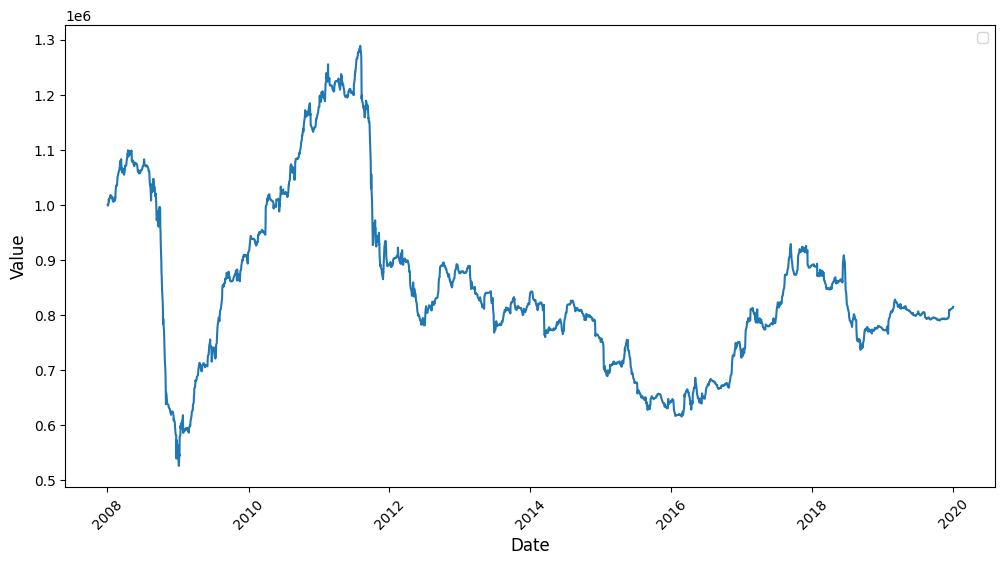

In [27]:
importlib.reload(vis)
vis.plot_time_series(agent.data['DATE'],
                     agent.portfolio_value)

In [ ]:
agent.print_model()

In [ ]:
# Takes about a minute
# Run experiment with 500 agents

importlib.reload(sim)
portfolio_values = []
for i in range(500):
    agent = sim.PortfolioAgent(
        data = dev_df[columns],
        date_col= 'DATE',
        price_delta_pred_bins_col = 'COPPER_OPEN_NOMINAL_PROPDELTA_PRED_BIN',
        price_delta_col = 'COPPER_OPEN_NOMINAL_PROPDELTA_PRED',
        learning_rate = 1, 
        explore_chance = 0.3, #Chance to take a random (legal) action
        rebalance_limit_steps = 2,  # Determine how far asset balances can be changed with each action
        asset_balance_steps = [x/10.0 for x in range(11)],)  # Possible asset balances; 0 is all cash, 1 is all copper futures)

    while True:
        if not agent.step(exploring=True, learning=True):
            break

    print('Agent ' + str(i) + ' complete')
    portfolio_values.append(agent.portfolio_value[agent.current_step])


In [28]:
np.median(portfolio_values)

859280.436715924

In [29]:
np.mean(portfolio_values)

885016.7815015471